# t-Distributed Stochastic Neighbor Embedding

<div style="margin:.3rem 0 1rem;font-size:.9em;color:#555;display:flex;align-items:center;gap:.35rem;font-family:monospace">
  <time datetime="2026-02-23">23 Feb 2026</time>
</div>

<a href="https://colab.research.google.com/github/shahaliyev/csci4701/blob/main/docs/supplementary/tsne.ipynb"
   target="_blank" rel="noopener">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open in Colab"
  />
</a>

  
Many datasets in [machine learning](../../introduction/02_machine_learning) contain hundreds or thousands of features, and it is almost impossible to see patterns in such spaces directly. Visualization helps us build intuition. If we can place the data in two or three dimensions while preserving its structure, clusters, groups, and relationships often become clear.

A good visualization method should keep nearby points close together and distant points far apart in the low-dimensional map. Many classical techniques, such as [Principal Component Analysis (PCA)](../pca), focus mainly on preserving global variance, which may hide local structure.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
    <em>Local structure</em> refers to relationships between very similar points, while <em>global structure</em> refers to the overall arrangement and large-scale distances in the dataset. Imagine a dataset of handwritten digits. Images of the digit $3$ should appear close to other $3$s, and
    $8$s should appear close to other $8s$ (local structure). At the same time, the distance between the group of $3$s and the group of $8$s should reflect how different those digits are overall (global structure).
  </p>
</div>

[Stochastic Neighbor Embedding (SNE)](https://www.cs.toronto.edu/~hinton/absps/sne.pdf) was introduced to address this problem. Instead of preserving distances directly, SNE converts distances into probabilities that represent how likely two points are to be neighbors. The algorithm then searches for a low-dimensional representation whose neighbor probabilities match those of the original high-dimensional data: points that are close in the original space should remain close in the map, and points that are far apart should rarely appear as neighbors.

[t-Distributed Stochastic Neighbor Embedding (t-SNE)](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) improved this idea. The original SNE method often struggled when many points needed to fit into a small space, a difficulty known as the *crowding problem*. t-SNE resolves this by modifying how similarities are measured in the low-dimensional space, allowing clusters to form more clearly and preventing unrelated points from collapsing together.

In this notebook we will build the t-SNE method step by step. The goal is to understand the mechanics behind it.

1. Convert distances between points into probabilities that represent how likely two points are neighbors.
2. Find a low-dimensional representation where those neighbor probabilities are preserved as closely as possible.
3. Examine why the original SNE method struggles, especially with the crowding problem and optimization difficulties.
4. Introduce the changes that produce t-SNE, including symmetric probabilities and the Student-t distribution.
5. Implement the t-SNE algorithm step by step to understand how each component works.
6. Apply the implementation to a real dataset such as MNIST to visualize structure in high-dimensional data.
7. Discuss the practical limitations of t-SNE and how its results should be interpreted.

We will follow the original paper while gradually building our intuition about the method. By the end of this notebook, we will have a working t-SNE implementation and a clear understanding of what its visualizations show (and what they do not).

## Preparing Dataset

To test our implementation we will use the MNIST dataset, where each image is $28 \times 28$ pixels, meaning every sample lies in a $784$-dimensional space. Both SNE and t-SNE rely on computing relationships between many pairs of points. In the straightforward implementation this requires computing pairwise distances between all samples. For a dataset with $n$ points this leads to the storage of an $n \times n$ similarity matrix. The time and memory complexity of the naive implementation are both $O(n^2)$. This quadratic scaling quickly becomes expensive. For example, using all 60,000 MNIST training images would require billions of pairwise comparisons and a very large probability matrix, which makes experimentation slow and memory-intensive.

For this reason, most introductory implementations work with a smaller subset of the data. This includes our implementation and the paper itself which conducts experiments only on 10% of the training data. This keeps the computations manageable while still revealing the structure of the dataset. More advanced implementations use approximations and data structures that reduce the cost, allowing t-SNE to scale to larger datasets.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

SUBSET_SIZE = 6000
torch.manual_seed(0)

dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
indices = torch.randperm(len(dataset))[:SUBSET_SIZE]
subset = Subset(dataset, indices)

X, y = next(iter(DataLoader(subset, batch_size=SUBSET_SIZE)))
X = X.flatten(1).float()

X.shape, y.shape

(torch.Size([6000, 784]), torch.Size([6000]))

## Applying PCA before SNE

We have noted the computational cost of t-SNE. For MNIST, $d = 784$. Even for a subset of $n = 6000$, distance computations are much heavier than in a smaller space. PCA helps for three practical reasons:

1. Reducing the dimension from $784$ to $30$ (as in the paper) makes distance computation about $\frac{784}{30} \approx 26$ times cheaper in the $O(n^2 d)$ part.

2. Pixel spaces like MNIST contain many correlated and low-variance directions (small fluctuations, background noise, redundant pixels). PCA concentrates most of the meaningful variation into the first components and discards directions that mostly add noise.

3. PCA is not meant to do the visualization, it is a preprocessing step that makes t-SNE faster and often more reliable. After PCA, t-SNE still performs the real job of building a 2D map from neighborhood probabilities.

PCA is therefore used only as a preprocessing step. After this reduction, SNE or t-SNE maps the data into a very low-dimensional space (typically two or three dimensions). Unlike PCA, this embedding is mainly intended for visualization. The goal is to reveal local structure such as clusters or groups of similar samples, rather than to produce a compact representation that can be reused for further modeling.

In [2]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)
emb = pca.fit_transform(X)

X = torch.from_numpy(emb).float()
X.shape

torch.Size([6000, 30])

## Calculating Conditional Probabilities

Our first step is to convert high-dimensional Euclidean distances between data points into conditional probabilities that represent pairwise similarities. To achieve that, we pass squared distances through a [Gaussian kernel](../../mathematics/03_probability):

$$
\text{similarity}(i,j) = \exp(-\|x_i - x_j\|^2 / (2\sigma_i^2)).
$$

The intuition is the following. Working directly with Euclidean distances is difficult when we want to compare neighborhoods across different regions of the dataset. Some areas of the data may be dense, while others are sparse. Using a Gaussian kernel converts distances into relative similarities: nearby points receive large values, while distant points quickly receive values close to zero.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
    Images of the digit $1$ are usually very similar to each other, so they lie close together in the feature space. Images of the digit $5$ can vary more in handwriting style, so they are more spread out. If we used raw Euclidean distances, the same distance threshold would behave differently in these regions. In the dense region many points would be counted as neighbors, while in the sparse region very few would. Using a Gaussian kernel converts distances into similarities, emphasizing nearby points while suppressing distant ones.
  </p>
</div>

The Gaussian kernel gives us a notion of similarity, but these values do not yet form probabilities. To obtain conditional probabilities we normalize the similarities:

$$
p_{j|i} = \frac{\text{similarity}(i,j)}{\sum_{k \ne i} \text{similarity}(i,k)}.
$$

This quantity can be interpreted as the probability that point $i$ would choose point $j$ as its neighbor if neighbors were selected according to the Gaussian distribution centered at $x_i$. The summation in the denominator runs over all points except $i$, since a point is not considered its own neighbor. Accordingly, $p_{i|i}$ is set to $0$.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
    This distribution is asymmetric: in general $p_{j|i} \ne p_{i|j}$. Each point defines its own neighborhood based on its local view of the data.
  </p>
</div>

In [3]:
def calc_dist_sq(X):
  dist = torch.cdist(X, X, p=2)
  dist_sq = dist**2
  dist_sq.fill_diagonal_(0)
  return dist_sq

dist_sq = calc_dist_sq(X)
dist_sq.shape

torch.Size([6000, 6000])

In [4]:
var = 1
eps = 1e-12 # for numerical stability

similarity = torch.exp(-dist_sq/(2*var))
similarity.fill_diagonal_(0) # p_ii = 0
similarity_sum = similarity.sum(dim=1, keepdim=True)
probs = similarity / (similarity_sum + eps)

probs[:5, :5], probs.shape

(tensor([[0.0000e+00, 3.8920e-07, 4.6595e-13, 6.2633e-09, 4.3093e-13],
         [3.6280e-05, 0.0000e+00, 6.7009e-15, 5.0127e-11, 2.4136e-08],
         [3.4942e-11, 5.3907e-15, 0.0000e+00, 2.5842e-16, 4.9600e-14],
         [2.5446e-09, 2.1847e-13, 1.4001e-18, 0.0000e+00, 4.1958e-14],
         [8.7613e-14, 5.2644e-11, 1.3448e-16, 2.0997e-14, 0.0000e+00]]),
 torch.Size([6000, 6000]))

Our current implementation is incomplete. Notice how probabilities depend on the chosen $\sigma^2$. Try out different $\sigma^2$ values to see how output changes.

The variance parameter controls how quickly similarity decreases with distance. A small $\sigma^2$ focuses on very close neighbors, while a larger $\sigma^2$ allows more points to be considered similar. In SNE, each point is allowed to have its own variance, which allows the method to adapt to different local densities in the data.

SNE determines the value of $\sigma_i^2$  by fixing the entropy of the conditional probability distribution around each point. This controls how many neighbors each point effectively considers. If the entropy is small, the distribution becomes concentrated on a few nearby points. If the entropy is large, the probability mass spreads across more neighbors. Recall that the Shannon entropy of the conditional distribution is

$$
\mathcal{H}(P_i) = -\sum_j p_{j|i}\log_2 p_{j|i}.
$$

Instead of specifying entropy directly, it is more intuitive to use **perplexity**, defined as

$$
\text{Perp}(P_i) = 2^{\mathcal{H}(P_i)}.
$$

Perplexity can be interpreted as a rough number of neighbors of a point. The algorithm performs a binary search over $\sigma^2_i$ so that the conditional distribution achieves the desired perplexity. Paper notes that perplexity values between $5$ and $50$ usually return stable results.

In [13]:
def calc_cond_prob(i, dist_sq_i, var_i, eps=1e-12):
  similarity_i = torch.exp(-dist_sq_i/(2*var_i))
  similarity_i[i] = 0
  prob_i = similarity_i / (similarity_i.sum() + eps)
  return prob_i

def calc_perplexity(prob_i, eps=1e-12):
  entropy = -prob_i.dot(torch.log2(prob_i + eps))
  return 2**entropy

def binary_search(dist_sq, perplexity=10, max_iter=30, var_range=(1e-8, 1e8), stop=1e-3):
  probs = torch.zeros_like(dist_sq)
  for i, dist_sq_i in enumerate(dist_sq):
    low, high = var_range
    for _ in range(max_iter):
      var_i = (low + high) / 2
      prob_i = calc_cond_prob(i, dist_sq_i, var_i)
      perp = calc_perplexity(prob_i)
      if torch.abs(perp - perplexity) < stop:
        break
      high, low = (var_i, low) if perp > perplexity else (high, var_i)
    probs[i] = prob_i
  return probs

In [14]:
probs = binary_search(dist_sq, perplexity=5, max_iter=30)
probs[:5, :5], probs.sum(dim=1)

(tensor([[0.0000e+00, 2.0020e-13, 3.8409e-26, 2.8199e-17, 3.2475e-26],
         [6.8740e-06, 0.0000e+00, 1.6775e-17, 7.0218e-13, 1.1141e-09],
         [3.3600e-22, 2.1917e-30, 0.0000e+00, 3.2178e-33, 2.5740e-28],
         [7.6604e-11, 1.0791e-15, 6.8749e-22, 0.0000e+00, 1.5071e-16],
         [0.0000e+00, 1.4553e-34, 0.0000e+00, 0.0000e+00, 0.0000e+00]]),
 tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]))

## Symmetric SNE

In the original SNE formulation, similarities are defined using conditional probabilities. Each point defines its own neighborhood, so in general $p_{j|i} \ne p_{i|j}$. This asymmetry can create difficulties during optimization. One point may strongly attract another, while the reverse influence is much weaker.  t-SNE addresses this issue by replacing the conditional probabilities with a symmetric measure of similarity between pairs of points. Instead of treating $p_{j|i}$ and $p_{i|j}$ separately, the algorithm combines them into a single joint probability:

$$
P_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}.
$$

Dividing by $2n$ ensures that the probabilities form a valid distribution over all pairs of points. Combining the two conditional probabilities preserves information from both local views of the data. If either point considers the other an important neighbor, the pair will receive a relatively large probability.

In [21]:
def symmetrize(probs, eps=1e-12):
  n = probs.shape[0]
  P = (probs + probs.T) / (2*n)
  P.fill_diagonal_(0)
  P = P / (P.sum() + eps)
  return P

P = symmetrize(probs)
P[:5, :5], P.sum()

(tensor([[0.0000e+00, 5.7559e-10, 2.8137e-26, 6.4144e-15, 2.7192e-30],
         [5.7559e-10, 0.0000e+00, 1.4046e-21, 5.8886e-17, 9.3286e-14],
         [2.8137e-26, 1.4046e-21, 0.0000e+00, 5.7566e-26, 2.1553e-32],
         [6.4144e-15, 5.8886e-17, 5.7566e-26, 0.0000e+00, 1.2619e-20],
         [2.7192e-30, 9.3286e-14, 2.1553e-32, 1.2619e-20, 0.0000e+00]]),
 tensor(1.0000))

## Heavy-Tailed Probability Map

After constructing the symmetric similarities $P_{ij}$ in the original space, the next step is to define a probability distribution in the low-dimensional map. If the points are placed at locations $y_i$ and $y_j$, the original SNE formulation measures similarity using a Gaussian kernel:

$$
\text{similarity}_{\text{low}}(i,j)
=
\exp(-\|y_i - y_j\|^2).
$$

These similarities are normalized to produce probabilities describing relationships between points in the map. Notice that unlike the high-dimensional case, the low-dimensional similarities do not include a variance parameter. In the original space each point needed its own scale because different regions of the dataset could have very different densities. In the map this is no longer necessary. Changing such a parameter would only stretch or shrink the entire embedding uniformly, and the optimization process can already adjust the scale by moving the points themselves.

However, this Gaussian formulation introduces an important difficulty. When many points from a high-dimensional space are projected into two or three dimensions, there is not enough room to preserve all pairwise relationships. Moderately distant points are forced closer together in the embedding. This phenomenon is known as the **crowding problem**. The Gaussian kernel makes this effect stronger because it decreases very quickly with distance. Once two points move slightly apart, their interaction rapidly becomes negligible while many other points still compete for limited space.

t-SNE addresses this by replacing the Gaussian with a [Student-t distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution), which has heavy tails. The method uses the Student-t distribution with one degree of freedom, which corresponds to the [Cauchy distribution](https://www.acsu.buffalo.edu/~adamcunn/probability/cauchy.html). This choice gives the similarity function heavier tails, meaning that points that are far apart still influence each other in the map.

$$
\text{similarity}_{\text{low}}(i,j)
=
\left(1 + \|y_i - y_j\|^2\right)^{-1}.
$$

This expression corresponds to the Student-t distribution with one degree of freedom. Choosing one degree of freedom produces particularly heavy tails, which helps reduce the crowding problem.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p style="margin: 1em 0;">
    One way to understand this distribution is to view it as a mixture of Gaussians with different variances. Instead of using a single fixed scale, the distribution effectively averages over many Gaussian kernels, some narrow and some very wide. This produces heavier tails and allows distant points to still exert a noticeable repulsive effect in the embedding.
  </p>
</div>

In [22]:
def calc_embed_map(dist_sq, eps=1e-12):
  similarity = 1/(1+dist_sq)
  similarity.fill_diagonal_(0)
  Q = similarity / (similarity.sum() + eps)
  return similarity, Q

The points in the low-dimensional space are initialized randomly with an isotropic Gaussian: $y_i \sim \mathcal{N}(0, \sigma^2 I)$. The variance is intentionally very small so that all points start close together. This avoids extremely large distances in the early stages of optimization and allows the structure of the data to gradually emerge. Random initialization also breaks symmetry. If all points started at the same location, the gradients would be identical and the algorithm would not be able to separate the points. Because of this randomness, different runs of t-SNE may produce slightly different embeddings.

In [23]:
def init_embed(probs, n_components=2, var=1e-2):
  return torch.randn(probs.shape[0], n_components) * var

Y = init_embed(probs)
Y[:5]

tensor([[-0.0195, -0.0003],
        [ 0.0041, -0.0026],
        [-0.0137, -0.0145],
        [ 0.0070, -0.0002],
        [-0.0090,  0.0014]])

## Optimizing t-SNE

After constructing the high-dimensional probabilities $P_{ij}$ and defining the low-dimensional probabilities $Q_{ij}$, the goal of t-SNE is to move the points in the map so that these two distributions become as similar as possible. t-SNE measures the mismatch between the two distributions using the [Kullback-Leibler (KL) divergence](../../mathematics/04_information):

$$
L = KL(P \parallel Q) =
\sum_{i \ne j} P_{ij} \log \frac{P_{ij}}{Q_{ij}}.
$$

This objective has an important interpretation:

- If $P_{ij}$ is large but $Q_{ij}$ is small, the cost increases strongly.  
- If $Q_{ij}$ is larger than $P_{ij}$, the penalty is smaller.

As a result, the algorithm strongly penalizes situations where true neighbors in the original space are placed far apart in the embedding. This encourages nearby points to stay close together in the map. On the other hand, if two points end up closer in the map than they were in the original space, the penalty is relatively mild. This allows the algorithm to make compromises when there is not enough room in two dimensions to preserve all distances perfectly. As a result, t-SNE prioritizes **local structure**: keeping similar points together is more important than perfectly representing all large-scale distances.

To minimize the cost, t-SNE computes the gradient of the KL-divergence objective with respect to the position of each point $y_i$. The full derivation of the following formula is noted in the appendix of the original paper:

$$
\nabla_{y_i} L
=
4
\sum_j
(P_{ij} - Q_{ij})
(y_i - y_j)
\left(1 + \|y_i - y_j\|^2\right)^{-1}.
$$

In the original paper, the authors interpret this expression like models in physics: as a system of forces acting between points in the embedding. If $P_{ij} > Q_{ij}$, the term becomes positive and the points move closer together (attract). If $Q_{ij} > P_{ij}$, the points push away from each other (repulse).

Because the Student-t distribution has heavy tails, the similarity between distant points decreases much more slowly than in a Gaussian. As a result, far points still exert a small but noticeable repulsive force during optimization. This additional long-range repulsion helps distribute points more evenly in the map and reduces the crowding problem.

The embedding is optimized using gradient descent. At each iteration the points are updated in the opposite direction of the gradient. In practice the update also includes [momentum](../../notebooks/04_regul_optim), which is a well-known technique to  accelerate convergence by accumulating velocity over time:

$$
v^{(t)} = \alpha v^{(t-1)} - \eta \frac{\partial C}{\partial Y},
$$

$$
Y^{(t+1)} = Y^{(t)} + v^{(t)}.
$$

The parameter $\alpha$ controls how much of the previous update is retained. Typical values used in t-SNE are $\alpha = 0.5$ during early iterations, and $\alpha = 0.8$ later in training. Momentum prevents oscillations and allows the optimization to move more smoothly across the loss surface.

t-SNE also uses a simple trick at the beginning of optimization. For the first iterations the probabilities are temporarily scaled: $P_{ij} \leftarrow 4 P_{ij}.$ This **early exaggeration** increases attractive forces between true neighbors and helps clusters form quickly before the global arrangement of the map stabilizes.

In [24]:
def calc_grad(P, Q, Y, similarity):
  diff = Y.unsqueeze(1) - Y.unsqueeze(0)
  weights = ((P - Q) * similarity).unsqueeze(2)
  return 4 * (weights * diff).sum(dim=1)

def calc_kl_div(P, Q, eps=1e-12):
  ratio = (P + eps) / (Q + eps)
  return (P * torch.log(ratio)).sum()

# sanity check
calc_kl_div(P, P)

tensor(0.)

In [ ]:
Y = init_embed(probs, var=1e-2)

# early exaggeration
P_orig = P
P_exag = P * 4

epochs = 500
lr = 1000
velocity = torch.zeros_like(Y)
alpha = 5.0

for e in range(epochs):
  alpha = 0.5 if e < 250 else 0.8
  P_use = P_exag if e < 100 else P_orig
  dist_sq = calc_dist_sq(Y)
  similarity, Q = calc_embed_map(dist_sq)
  loss = calc_kl_div(P_use, Q)
  grad = calc_grad(P_use, Q, Y, similarity)
  velocity = alpha*velocity - lr*grad
  Y += velocity
  Y -= Y.mean(dim=0, keepdim=True) # centering embedding

  if e % 50 == 0:
     print(f"Epoch: {e}, Loss {loss.item():.4f}")

## Visualizing Embeddings

After optimization, each data point has a new position in a two-dimensional space.  Points that were considered neighbors in the original high-dimensional space should now lie close together in the map, while unrelated points should appear farther apart.

To examine the result, we plot the embedding and color each point according to its true label. If the algorithm has successfully captured the local structure of the dataset, points representing the same digit should form visible groups.

Because the absolute orientation of the embedding is arbitrary, the axes themselves do not carry meaning. Rotating or flipping the map does not change the relationships between points. What matters is the relative arrangement of clusters and how well similar samples group together.

In [32]:
import matplotlib.pyplot as plt

def plot_tsne(Y, labels, title=None):
    Y = Y.detach().cpu() if hasattr(Y, "detach") else torch.tensor(Y)
    labels = labels.detach().cpu() if hasattr(labels, "detach") else torch.tensor(labels)
    Y = Y - Y.mean(dim=0)
    Y = Y / (Y.std(dim=0) + 1e-8)
    plt.figure(figsize=(6, 6))
    plt.scatter(
        Y[:, 0],
        Y[:, 1],
        c=labels,
        cmap="tab10",
        s=6,
        linewidths=0
    )
    if title:
        plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

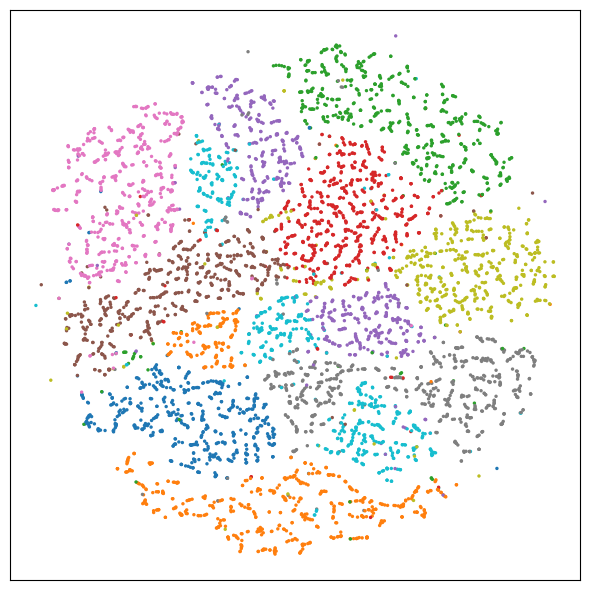

In [33]:
plot_tsne(Y, y)

## Conclusion

In this notebook we implemented the main ideas behind Stochastic Neighbor Embedding and its improved variant, t-Distributed Stochastic Neighbor Embedding. Instead of preserving distances directly, the method converts pairwise distances into probability distributions that describe how likely points are to be neighbors. The embedding is then learned by minimizing the mismatch between the high-dimensional and low-dimensional distributions.

The key modification introduced by t-SNE is the use of a heavy-tailed Student-t distribution in the embedding space. This reduces the crowding problem and allows clusters to separate more clearly. When applied to MNIST, the method reveals meaningful structure: images of the same digit tend to appear close together even though the original data lives in a very high-dimensional space.

The paper also points out several important limitations. The basic algorithm has quadratic time and memory complexity, which makes large datasets expensive to process without approximations. The optimization problem is non-convex, so different runs can produce different layouts depending on initialization and hyperparameters. In addition, t-SNE focuses on preserving local neighborhoods, which means that global distances between clusters should not be interpreted too strictly.